<a href="https://colab.research.google.com/github/soniaeya/NLP_A1_Guide/blob/master/Copy_of_assignment1_guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assigment 2: Word2vec and CBOW ⚡


In this assignment, we will guide you through the process of implementing Continous Bag Of Words (CBOW) using PyTorch, providing step-by-step instructions, code snippets, and explanations to aid your understanding. By the end of this assignment, you will have a solid grasp of Word2Vec's mechanics and be equipped to apply this knowledge to a wide range of NLP tasks.

Let's embark on this journey to unlock the power of word embeddings with Word2Vec and PyTorch!

This [guide](https://pytorch.org/tutorials/beginner/basics/intro.html) might come in handy to understand how Pytorch works.

Let's start by installing the needed libraries

In [39]:
!pip install gensim

In [40]:
import torch
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In this assigment we will use the dataset *text8*. This dataset is composed of textual content extracted from Wikipedia articles which hopefully will lead to good embeddings when input in CBOW.

In [41]:
import gensim.downloader as api

dataset = list(api.load("text8"))[0:3] #We trim the dataset to make training as long. Feel free to change this based on your resources

Let's have a look at a datapoint.

In [42]:
(" ").join(dataset[0])

'anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in place of what are regarded as authoritarian political structures and coercive economic instituti

Normally we would need to do some data preprocessing in order to clean our dataset but lucky for you the professor chose a pretty and clean dataset so you don't have to 😉

Let's start to get more on topic. If you remember, Word2Vec has a specific way of generating each vector.
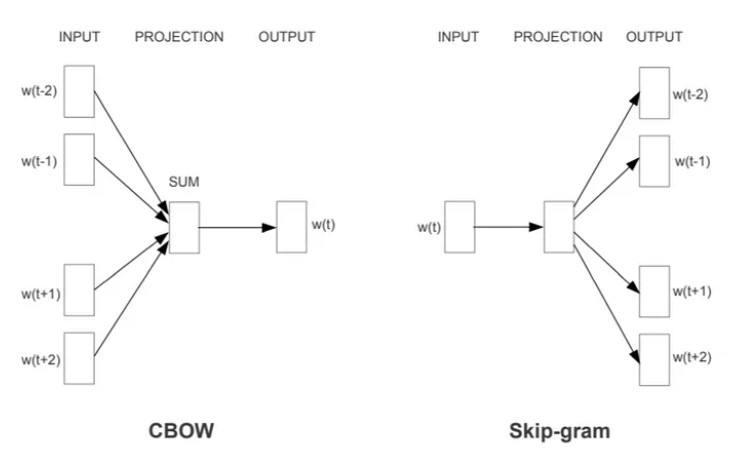

The embedding is based on the surrounding words (before and after) taken as context. In the case of CBOW, we input the surrounding words to our neural network and expect that it predicts the middle word. Let's format our dataset to meet the needs of the neural network.


Since our neural networks can't understand strings we have to turn these strings into integers. In this case, we can use the one hot encodings to represent the words, so we will need the mapping: word -> one-hot-encoding

In [43]:
import pandas as pd
import torch
import torch.nn.functional as F

def create_word_to_index(vocab_list):
  """ Method that creates dictionary that maps words to an index.
  Arguments
  ---------
  vocab_list : list(String)
    List of words in the vocabulary
  Returns
  -------
  word_to_index : Dictionary
    Dictionary mapping words to index with format {word:index}
  """
  word_to_index = {}

  for i,word in enumerate(vocab_list):
    word_to_index[word] = i
  return word_to_index

vocab_list = list(set(word for sentence in dataset for word in sentence))
word_to_index = create_word_to_index(vocab_list)

In [44]:
def generate_dataset(dataset, window_size,word_to_index):
  """ Method to generate training dataset for CBOW.
  Arguments
  ---------
  data : String
     Training dataset
  window_size : int
     Size of the context window
  word_to_index : Dictionary
     Dictionary mapping words to index with format {word:index}
  Returns
  -------
  surroundings : N x W Tensor
      Tensor with index of surrounding words, with N being the number of samples and W being the window size
  targets : Tensor
      Tensor with index of target word
  """
  surroundings= []
  targets = []

  # TODO complete the following
  for data in dataset:
    for i in range(window_size,len(data)-window_size): # i = idx of target word
      surrounding = [word_to_index[data[j]] for j in range (i - window_size, i + window_size + 1) if j != i]
      surrounding = torch.tensor(surrounding)
      target = word_to_index[data[i]] #get index of target word
      surroundings.append(surrounding)
      targets.append(target)

  surroundings = torch.stack(surroundings)
  targets = torch.tensor(targets)
  return surroundings, targets


WINDOW_SIZE = 2
surroundings, targets = generate_dataset(dataset,WINDOW_SIZE,word_to_index)
generate_dataset(dataset,WINDOW_SIZE,word_to_index)




(tensor([[5083, 3156, 5051,  743],
         [3156, 1194,  743, 1736],
         [1194, 5051, 1736, 1047],
         ...,
         [3741, 5211, 2796, 4462],
         [5211, 2003, 4462, 1013],
         [2003, 2796, 1013, 1459]]),
 tensor([1194, 5051,  743,  ..., 2003, 2796, 4462]))

With our dataset ready we can finally create our Neural Network. The idea is to replicate what Mikolov did in 2013 (see slides of Word2Vec).

In [51]:
import torch.nn as nn
class CBOW(nn.Module):
  def __init__(self, vocab_size, embed_dim=300):
    """ Class to define the CBOW model
    Attributes
    ---------
    device : device
      Device where the model will be trained (gpu preferably)
    vocab_size : int
      Size of the vocabulary
    embed_dim : int
      Size of the embedding layer
    hidden_dim : int
      Size of the hidden layer

    """
    super().__init__()

    self.device = device
    self.vocab_size = vocab_size # input size
    self.embed_dim = embed_dim
    self.hidden_dim = 128 # Define hidden_dim before using it

    self.embedding = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embed_dim)
    self.linear_in = nn.Linear(self.embed_dim, self.hidden_dim, bias=False)# Linear layer that encodes one-hot-encoding to embedding dimension. Remember Mikolov's implementation had NO BIAS
    self.linear_out = nn.Linear(self.hidden_dim, self.vocab_size, bias=False)# Linear layer that decodes from embedding dimension to vocab dimension. Remember Mikolov's implementation had NO BIAS

  def forward(self, x):
    emb = self.embedding(x) #pass input (indices of surrounding words) through embedding layer
    average = torch.mean(emb, dim = 1) #average embeddings
    out = self.linear_in(average)  #pass through linear layer
    out = self.linear_out(out) #pass through output linear layer

    return out

We will need an important function that creates one hot encoding vectors based on our surrounding word's indexes

In [46]:
def one_hot_from_surroundings(surroundings,window_size, vocab_size):
  """ Method to create one hot encodings for the surrounding words.
  Arguments
  ---------
  surroundings : N x (Wx2) Tensor
     Tensor with index of surrounding words, with N being the number of samples and W being the window size
  vocab_size : int
     Size of the vocabulary
  Returns
  -------
  one_hot_surroundings : N x (Wx2) x V Tensor
      Tensor with one hot encodings of surrounding words, with N being the number of samples, W being the window size and V being the vocabulary size
  """
  one_hot_surr = torch.nn.functional.one_hot(surroundings, num_classes=vocab_size)
  return one_hot_surr


In [47]:
#Check if your previous function is correct
index= [[2,3,7,8],[0,1,9,5]]
index_tensor = torch.tensor(index).to(device)
answer = torch.tensor([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]], device=device)

prediction = one_hot_from_surroundings(index_tensor,2,10)
assert prediction.shape == torch.Size([2, 4, 10]), "Make sure the result has shape NUM_EXAMPLES X WINDOW_SIZE*2 X VOCAB_SIZE"
assert torch.equal(prediction,answer), "Wrong implementation of one_hot_from_surroundings method"
print("Good Job!")

Good Job!


Now we are finally ready to train

In [48]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
#creation of dataloader for training
full_dataset = list(zip(surroundings,targets))
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_dataloader=DataLoader(train_dataset,batch_size=8,shuffle=True) #Here please change batch size depending of your GPU capacities (if GPU runs out of memory lower batch_size)
val_dataloader=DataLoader(val_dataset,batch_size=8,shuffle=False) #Here please change batch size depending of your GPU capacities (if GPU runs out of memory lower batch_size)

In [53]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #CAUTION: RUN THIS CODE WITH GPU, CPU WILL TAKE TOO LONG
EMB_DIM = 300
CBOW_MODEL = CBOW(len(word_to_index), embed_dim= EMB_DIM).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CBOW_MODEL.parameters(), lr=0.001)
EPOCHS = 5

#BE PATIENT: This code can take up to 1 hours for a batch size of 64 and 5 epochs

def train_model(model, train_loader, val_loader, epochs=5, lr=1e-3):
  total_loss = 0
  i=0
  for surr, tar in tqdm(train_dataloader,"Training"):
      # TODO complete
      surr, tar = surr.to(device), tar.to(device)
      # one_hot_surr = one_hot_from_surroundings(surr,WINDOW_SIZE, len(word_to_index)) # Remove this line

      optimizer.zero_grad()
      log_probs = model(surr) # Pass indices through model

      loss= loss_function(log_probs,tar)
      total_loss += loss.item()

      loss.backward()
      optimizer.step()

  return total_loss/len(train_dataloader)
def evaluate_model(model, val_loader):
  model.eval()
  total_loss = 0
  with torch.no_grad():
      for surr, tar in tqdm(val_loader, "Validation"):
          surr, tar = surr.to(device), tar.to(device)
          # one_hot_surr = one_hot_from_surroundings(surr,WINDOW_SIZE, len(word_to_index)) # Remove this line

          log_probs = model(surr) # Pass indices through model

          loss= loss_function(log_probs,tar)
          total_loss += loss.item()
  return total_loss/len(val_loader)


for epoch in range(EPOCHS):
  train_loss = train_model(CBOW_MODEL, train_dataloader, val_dataloader, epochs=1, lr=0.001)
  val_loss = evaluate_model(CBOW_MODEL, val_dataloader)
  print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Validation: 100%|██████████| 750/750 [00:00<00:00, 2619.56it/s]


Epoch 1, Train Loss: 7.4072, Val Loss: 7.1435


Validation: 100%|██████████| 750/750 [00:00<00:00, 2589.75it/s]


Epoch 2, Train Loss: 5.9150, Val Loss: 7.0212


Validation: 100%|██████████| 750/750 [00:00<00:00, 2616.76it/s]


Epoch 3, Train Loss: 4.6851, Val Loss: 7.3102


Validation: 100%|██████████| 750/750 [00:00<00:00, 2636.13it/s]


Epoch 4, Train Loss: 3.5034, Val Loss: 7.8702


Validation: 100%|██████████| 750/750 [00:00<00:00, 2451.46it/s]


Epoch 5, Train Loss: 2.5523, Val Loss: 8.5256


## Let's test it!

Now that we hopefully have good embeddings we can put them to the test. Let's start by creating some useful functions.

In [68]:
def create_word_to_embedding (vocab_list, model,word_to_index):
  """ Method to get create dictionary that maps a word to it's embedding vector.
  Arguments
  ---------
  word : String
     Word given
  model : NN.module
     CBOW model
  word_to_index : Dictionary
     Dictionary mapping words to index with format {word:index}
  Returns
  -------
  word_embedding : Tensor
      Embedding vector for the given word
    """
  embedding_weights = model.embedding.weight # Get the weights of the embedding layer (remove .detach() and .cpu())
  word_to_embedding = {}
  for word in vocab_list:
    index=  word_to_index[word] # Get word index
    word_embedding = embedding_weights[index, :] # Extract the embedding vector for the given word index. This is done by getting the row of the index specified
    word_to_embedding[word] = word_embedding

  return word_to_embedding

word_to_embedding = create_word_to_embedding(vocab_list,CBOW_MODEL,word_to_index)
if 'study' in word_to_embedding:
  print("Embedding of word 'study'", word_to_embedding['study'])
else:
  print("Word 'study' not found in the vocabulary.")

Embedding of word 'study' tensor([ 0.3440,  0.6325,  0.9098,  0.8740, -0.3574,  1.0603, -0.6550,  1.1914,
        -0.9184,  0.3033, -1.2627, -0.2020,  0.6620, -0.2983,  0.6093,  0.6314,
         2.4007, -0.0387,  1.2296, -0.5365, -0.2670,  1.3016,  0.0062,  1.1588,
        -0.2767, -0.7970,  1.1360,  0.1074,  0.4604, -1.2527,  1.2652,  0.2764,
        -0.7204, -1.2502,  0.0539,  0.8522, -0.8009,  1.1083, -1.0149,  1.3148,
        -0.2585, -1.4544, -0.0135, -1.1048,  0.3322, -1.6874,  0.3764,  0.2492,
         0.1340,  1.1358,  0.2915, -0.3602,  2.0238, -0.3496, -1.2286,  0.0443,
         0.3748, -1.4496, -0.2109,  0.6152,  1.0671, -0.0208, -0.0912,  0.3316,
        -2.2442,  0.0793, -2.5027,  0.6564, -0.2658, -1.6538, -0.6152, -1.3131,
        -1.1543,  0.2197, -0.6158,  1.0296, -0.3400,  1.0766,  0.0095,  3.2152,
        -0.3825,  0.3148,  0.1898,  0.2715, -0.5421, -1.6504,  0.2375, -0.1322,
         1.0052,  1.8254, -2.1434, -0.9131, -2.4094, -0.8207,  0.4785,  0.4041,
        -0.678

We will test how good our word2vec model is by testing the embeddings on the downstream task of sentiment analysis of movies 🎥

Let's first import and download this dataset.


In [58]:
from keras.datasets import imdb

def decode_review(word_index, review):
  decoded_review = " ".join([reverse_word_index.get(i - 3, "") for i in review])
  return decoded_review

(train_data, train_labels), (test_data, test_labels)= imdb.load_data(num_words=10000)
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

# We will trim the dataset to not make training to long, feel free to change this based on your resources
train_data = train_data[:10000]
train_labels = train_labels[:10000]
test_data = test_data[:2000]
test_labels = test_labels[:2000]

#Decode data
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}
train_data = [decode_review(reverse_word_index,x) for x in train_data]
test_data = [decode_review(reverse_word_index,x) for x in test_data]

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Now we can create a simple Sentiment classifier that will use our embeddings from our CBOW model. The model input will be an average of the word embeddings of the review and the output will be a binary: positive🙂 or negative😞.

Let's start by creating our Dataloaders

In [76]:
from torch.utils.data import Dataset, DataLoader

class ReviewDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = reviews
        self.labels = labels

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return self.reviews[idx], self.labels[idx]


def get_review_embedding(review):
  """ Method to get the embedding vector for a given review.
  Arguments
  ---------
  review : String
     Review given
  model : NN.module
     CBOW model
  word_to_index : Dictionary
     Dictionary mapping words to index with format {word:index}
  Returns
  -------
  review_embedding : Tensor
      Embedding vector for the given review
  """
  # TODO write a function that gets sentence embedding by averaging the embeddings of the words in the review (only take into account words in vocab)
  words = review.split()
  sum_embeddings = torch.zeros(list(word_to_embedding.values())[0].shape, device=device, requires_grad=True) # Explicitly set requires_grad=True
  count = 0
  for word in words:
    if word in word_to_embedding:
      # Ensure embedding is on the correct device and add to sum_embeddings
      # Use .clone() to avoid modifying the original tensor in word_to_embedding
      sum_embeddings = sum_embeddings + word_to_embedding[word].to(device)
      count += 1
  if count > 0:
    review_embedding = sum_embeddings / count
  else:
    # Return a zero vector with requires_grad=True
    review_embedding = torch.zeros(list(word_to_embedding.values())[0].shape, device=device, requires_grad=True)

  return review_embedding


def create_dataloader_imdb(train_data, train_labels, test_data, test_labels, batch_size= 64):
  """ Method to create dataloaders for the IMDB dataset
  Arguments
  ---------
  train_data : List
     List of reviews for training
     train_labels : List
     List of labels for training
  test_data : List
     List of reviews for testing
  test_labels : List
     List of labels for testing
  Returns
  -------

  """
  train_dataset = ReviewDataset(train_data, train_labels)
  test_dataset = ReviewDataset(test_data, test_labels)


  train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
  test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
  return train_dataloader, test_dataloader


train_dataloader_imd , test_dataloader_imd = create_dataloader_imdb(train_data, train_labels, test_data, test_labels)

Let's create a very simple MLP for this classification problem

In [74]:
class SentimentClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=128, num_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
      # TODO complete forward
      return x


Now the fun part, time to train

In [78]:
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #CAUTION: RUN THIS CODE WITH GPU, CPU WILL TAKE TOO LONG
SENT_MODEL = SentimentClassifier(embedding_dim=EMB_DIM).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(SENT_MODEL.parameters(), lr=0.001)
EPOCHS = 5

#BE PATIENT: This code can take up to 1 hours for a batch size of 64 and 5 epochs

def train_model(model, train_loader):
  model.train()
  total_loss = 0
  for reviews, y in tqdm(train_loader,"Training"):
    # Calculate review embeddings dynamically with gradient tracking
    X = torch.stack([get_review_embedding(review) for review in reviews]).to(device)
    y = y.to(device) # Move labels to device

    optimizer.zero_grad() # Zero the gradients
    out = model(X) # Forward pass
    loss = loss_function(out, y) # Calculate the loss
    loss.backward() # Backpropagate the error
    optimizer.step() # Update the weights

    total_loss += loss.item()

  return total_loss/len(train_loader)

def evaluate_model(model, val_loader):
  model.eval()
  correct, total = 0, 0
  all_predictions = []
  all_labels = []
  with torch.no_grad():
    for reviews, y in tqdm(val_loader,"Validation"):
        # Calculate review embeddings dynamically (without gradient tracking for evaluation)
        X = torch.stack([get_review_embedding(review) for review in reviews]).to(device)
        y = y.to(device) # Move labels to device

        out = model(X) # Forward pass
        preds = torch.softmax(out, dim=1)  # Pass through softmax layer
        preds = torch.argmax(preds, dim=1)  #Get prediction by doing argmax
        correct += (preds == y).sum().item() # Check how many are correct
        all_predictions.extend(preds.cpu().numpy()) # Save predictions
        all_labels.extend(y.cpu().numpy()) # Save labels
        total += y.size(0)
  acc = correct / total
  return acc, all_predictions, all_labels

for epoch in range(EPOCHS):
  train_loss = train_model(SENT_MODEL, train_dataloader_imd)
  validation_accuracy , predictions, labels= evaluate_model(SENT_MODEL, test_dataloader_imd)
  print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

Validation: 100%|██████████| 32/32 [00:03<00:00,  8.02it/s]


Epoch 1, Train Loss: 5.7479, Validation Accuracy: 0.0025


Validation: 100%|██████████| 32/32 [00:03<00:00,  8.66it/s]


Epoch 2, Train Loss: 5.7483, Validation Accuracy: 0.0025


Validation: 100%|██████████| 32/32 [00:03<00:00,  9.37it/s]


Epoch 3, Train Loss: 5.7477, Validation Accuracy: 0.0025


Validation: 100%|██████████| 32/32 [00:03<00:00,  9.21it/s]


Epoch 4, Train Loss: 5.7478, Validation Accuracy: 0.0025


Validation: 100%|██████████| 32/32 [00:03<00:00,  9.16it/s]

Epoch 5, Train Loss: 5.7478, Validation Accuracy: 0.0025


Calculate precision, recall and F-measure of our Sentiment Analysis model. Also plot Confusion Matrix

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.4363
Recall: 0.0025
F1 Measure: 0.0050


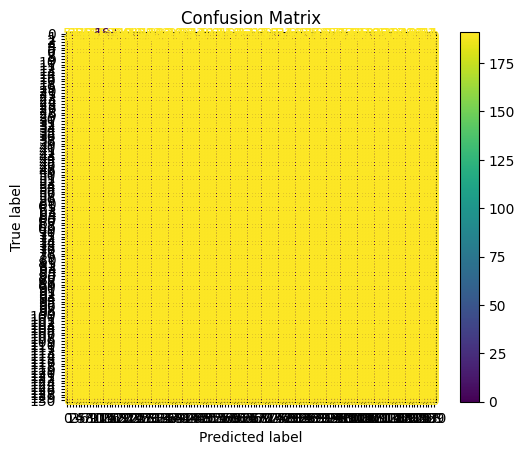

In [81]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# You have already a np.array of labels and predictions

#TODO calculate precision, recall and F1 measure and print Confusion Matrix

# Calculate precision, recall, and F1 measure
precision = precision_score(labels, predictions, average='weighted')
recall = recall_score(labels, predictions, average='weighted')
f1 = f1_score(labels, predictions, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Measure: {f1:.4f}")

# Calculate and plot the confusion matrix
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# Let's Experiment! 🤓

Pick 3 of the following experiments and develop a solution **in this same notebook**. Take advange of the notebook structure to give a clear structure of experiment -> conclusions

1. Compare with another pretrained word2vec model
2. Experiment with a different sentiment analysis dataset (might require change in architecture of sentiment analyser)
3. Train your CBOW model on a different train set (might require data preprocessing)
4. Play with hyperparameters (window size, embedding dimension)
